<a id="top"></a>
# Using the ULLYSES coaddition algorithm

***

## Learning Goals

**NOTE**: It is recommended that you read/work through the `ullyses-walkthrough.ipynb` first before running this notebook.

By the end of this tutorial, you will:

- learn how to create ULLYSES coadded and abutted products
- learn how to create coadded and abutted products for non-ULLYSES data

## Table of Contents
**0. [Introduction](#introduction)**

**1. [Obtain Data](#sec1)**

**2. [Coadding and abutting ULLYSES data](#sec2)**

\- 2.1 [Coadding data in a directory](#sec21)

\- 2.2 [Coadding a list of data files](#sec22) 

\- 2.2 [Inspect output products](#sec23)

**3. [Coadding non-ULLYESS data](#sec3)**

\- 3.1 [Inspect output products](#sec31)

<a id="introduction"></a>
## Introduction

The Hubble Space Telescope’s (HST) Ultraviolet Legacy Library of Young Stars as Essential Standards ([ULLYSES](https://ullyses.stsci.edu/index.html) program has devoted approximately 1,000 HST orbits to the production of an ultraviolet spectroscopic library of young high- and low-mass stars in the local universe. 

The ULLYSES team produces several types of High Level Science Products (HLSPs). Products are made using both archival HST/FUSE data and new HST observations obtained through the ULLYSES program. Data of the same target and same grating are coadded, as described [here](https://ullyses.stsci.edu/ullyses-data-description.html#CoaddSpectra). Data of the same target, but different gratings and/or instruments, are abutted as described [here](https://ullyses.stsci.edu/ullyses-data-description.html#AbutSpectra).

In this notebook we will show how to create coadded and abutted spectral products for ULLYSES data, and coadded products for non-ULLYSES data.

### Imports
We need only access to basic python packages, astropy for reading FITS files, matplotlib for plotting, and the ullyses package to coadd and abut data.

In [1]:
import os
import glob
from astropy.io import fits

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=13,6
plt.style.use('seaborn-v0_8-notebook')

from ullyses.ullyses_coadd_abut_wrapper import main, coadd_and_abut_files
from ullyses.generic_coadd_wrapper import coadd_files

***

<a id="sec1"></a>
## Obtain Data

To download data, we will retrieve it directly from MAST. For this example, we will simply download the ULLYSES observations of target AV-175. This includes three COS/G130M cenwave 1291 datasets and five COS/G160M cenwave 1611 datasets.

These datasets will download into a new folder in your current working directory, called `notebook_download/`.

In [2]:
!curl -L -X GET "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=LEEY3C010%2Fleey3ce5q_x1d.fits" --output "notebook_download/leey3ce5q_x1d.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=LEEY3C010%2Fleey3ce8q_x1d.fits" --output "notebook_download/leey3ce8q_x1d.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=LEEY3C010%2Fleey3cefq_x1d.fits" --output "notebook_download/leey3cefq_x1d.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=LEEY3C020%2Fleey3cejq_x1d.fits" --output "notebook_download/leey3cejq_x1d.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=LEEY3C020%2Fleey3cemq_x1d.fits" --output "notebook_download/leey3cemq_x1d.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=LEEY3C020%2Fleey3cepq_x1d.fits" --output "notebook_download/leey3cepq_x1d.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=LEEY3C020%2Fleey3cesq_x1d.fits" --output "notebook_download/leey3cesq_x1d.fits" --fail --create-dirs

!curl -L -X GET "https://mast.stsci.edu/search/hst/api/v0.1/retrieve_product?product_name=LEEY3C020%2Fleey3ceyq_x1d.fits" --output "notebook_download/leey3ceyq_x1d.fits" --fail --create-dirs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3310k    0 3310k    0     0  2379k      0 --:--:--  0:00:01 --:--:-- 2383k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3310k    0 3310k    0     0  3611k      0 --:--:-- --:--:-- --:--:-- 3629k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3310k    0 3310k    0     0  3453k      0 --:--:-- --:--:-- --:--:-- 3466k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3310k    0 3310k    0     0  3876k      0 --:--:-- --:--:-- --:--:-- 13620     0 --:--:-- --:--:-- --:--:-- 3885k
  % Total    

***

<a id="sec2"></a>
## Coadd and abut ULLYSES data

To create coadded and abutted products for ULLYSES data, specific information about the ULLYSES target is looked up on-the-fly during processing. This includes the officially designated target name and coordinates, which are stored in the output header.

Data can be coadded and abutted by either specifying:
1. An input directory, or
2. A list of input files (which could be located across different directories)

Additionally, you must supply an output directory. Optional arguments include: a version number for the output filenames and specifying whether existing products should be overwritten.

Output filenames have the form:

`hlsp_ullyses_<telescope>_<instrument>_<target>_<opt_elem>_<version>_<product-type>`

where

`<target>` is the target name

`<version>` is the data release identifier (dr1, dr2, etc.)

`<telescope>`, `<instrument>`, `<opt_elem>`, and `<product-type>` are populated as specified [here](https://ullyses.stsci.edu/ullyses-data-description.html#productDescrip).

<a id="sec21"></a>
### Coadding data in a directory

In [3]:
# First define the input and output directories
indir = "notebook_download"
indir_method_outdir = "coadd_ullyses_indir"

In [4]:
main(indir, indir_method_outdir, version="dr7", clobber=True)

notebook_download
   notebook_download
notebook_download/leey3cepq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3ceyq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3cejq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3cemq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3cesq_x1d.fits added to file list for instrument/grating COS/G160M


/Users/jotaylor/miniconda3/envs/ullyses_dr7/lib/python3.9/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']
/Users/jotaylor/miniconda3/envs/ullyses_dr7/lib/python3.9/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


   Wrote coadd_ullyses_indir/hlsp_ullyses_hst_cos_av-224_g160m_dr7_cspec.fits
notebook_download/leey3ce5q_x1d.fits added to file list for instrument/grating COS/G130M
notebook_download/leey3ce8q_x1d.fits added to file list for instrument/grating COS/G130M
notebook_download/leey3cefq_x1d.fits added to file list for instrument/grating COS/G130M


   Wrote coadd_ullyses_indir/hlsp_ullyses_hst_cos_av-224_g130m_dr7_cspec.fits


   Wrote coadd_ullyses_indir/hlsp_ullyses_hst_cos_av-224_g130m-g160m_dr7_aspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1131.3-1428.4)
COS/G160M 1342-1800 (Actual: 1418.4-1789.6)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1428.4016896086262
Truncating current grating at 1789.5522227060096
   Wrote coadd_ullyses_indir/hlsp_ullyses_hst_cos_av-224_uv_dr7_preview-spec.fits


<a id="sec22"></a>
### Coadding a list of data files

In [5]:
# First define the input and output directories
indir = "notebook_download"
infiles_method_outdir = "coadd_ullyses_infiles"

In [6]:
# Determine list of input files on the fly, or you could specify a specific list
infiles = glob.glob(os.path.join(indir, "*fits"))
coadd_and_abut_files(infiles, infiles_method_outdir, version="dr7", clobber=True)

/Users/jotaylor/miniconda3/envs/ullyses_dr7/lib/python3.9/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


notebook_download/leey3cepq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3ceyq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3cejq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3cemq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3cesq_x1d.fits added to file list for instrument/grating COS/G160M


/Users/jotaylor/miniconda3/envs/ullyses_dr7/lib/python3.9/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


   Wrote coadd_ullyses_infiles/hlsp_ullyses_hst_cos_av-224_g160m_dr7_cspec.fits
notebook_download/leey3ce5q_x1d.fits added to file list for instrument/grating COS/G130M
notebook_download/leey3ce8q_x1d.fits added to file list for instrument/grating COS/G130M
notebook_download/leey3cefq_x1d.fits added to file list for instrument/grating COS/G130M


   Wrote coadd_ullyses_infiles/hlsp_ullyses_hst_cos_av-224_g130m_dr7_cspec.fits


   Wrote coadd_ullyses_infiles/hlsp_ullyses_hst_cos_av-224_g130m-g160m_dr7_aspec.fits
Making a product from these gratings
COS/G130M 900-1470 (Actual: 1131.3-1428.4)
COS/G160M 1342-1800 (Actual: 1418.4-1789.6)
Transition wavelengths tweaked
Transition wavelengths tweaked
Starting at the short wavelength end with grating COS/G130M
Abutting COS/G160M product to current result
With a transition wavelength of 1428.4016896086262
Truncating current grating at 1789.5522227060096
   Wrote coadd_ullyses_infiles/hlsp_ullyses_hst_cos_av-224_uv_dr7_preview-spec.fits


<a id="sec23"></a>
### Inspect output products

First, let's ensure that the products created using both methods above are identical.

In [7]:
indir_products = glob.glob(os.path.join(indir_method_outdir, "*fits"))
for indir_item in indir_products:
    infiles_item = os.path.join(infiles_method_outdir, os.path.basename(indir_item))
    fd = fits.FITSDiff(indir_item, infiles_item)
    print(fd.report())


 fitsdiff: 6.0.0
 a: coadd_ullyses_indir/hlsp_ullyses_hst_cos_av-224_uv_dr7_preview-spec.fits
 b: coadd_ullyses_infiles/hlsp_ullyses_hst_cos_av-224_uv_dr7_preview-spec.fits
 Maximum number of different data values to be reported: 10
 Relative tolerance: 0.0, Absolute tolerance: 0.0

No differences found.


 fitsdiff: 6.0.0
 a: coadd_ullyses_indir/hlsp_ullyses_hst_cos_av-224_g130m_dr7_cspec.fits
 b: coadd_ullyses_infiles/hlsp_ullyses_hst_cos_av-224_g130m_dr7_cspec.fits
 Maximum number of different data values to be reported: 10
 Relative tolerance: 0.0, Absolute tolerance: 0.0

No differences found.


 fitsdiff: 6.0.0
 a: coadd_ullyses_indir/hlsp_ullyses_hst_cos_av-224_g130m-g160m_dr7_aspec.fits
 b: coadd_ullyses_infiles/hlsp_ullyses_hst_cos_av-224_g130m-g160m_dr7_aspec.fits
 Maximum number of different data values to be reported: 10
 Relative tolerance: 0.0, Absolute tolerance: 0.0

No differences found.


 fitsdiff: 6.0.0
 a: coadd_ullyses_indir/hlsp_ullyses_hst_cos_av-224_g160m_dr7_

Now let's compare the input x1d files to the output coadded and abutted products. We can find the files that contributed to product in the `PROVENANCE`, or 2nd, extension.

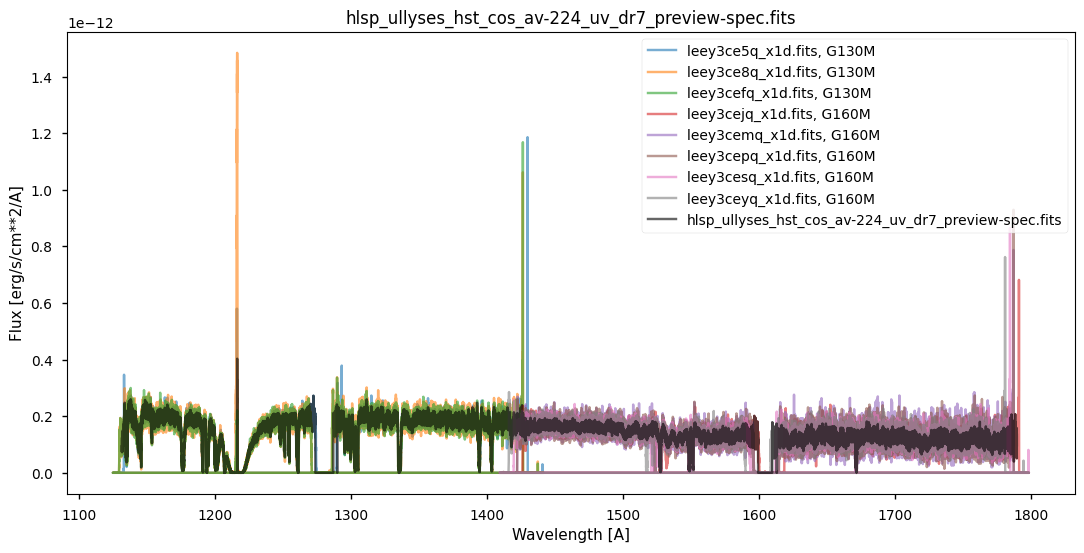

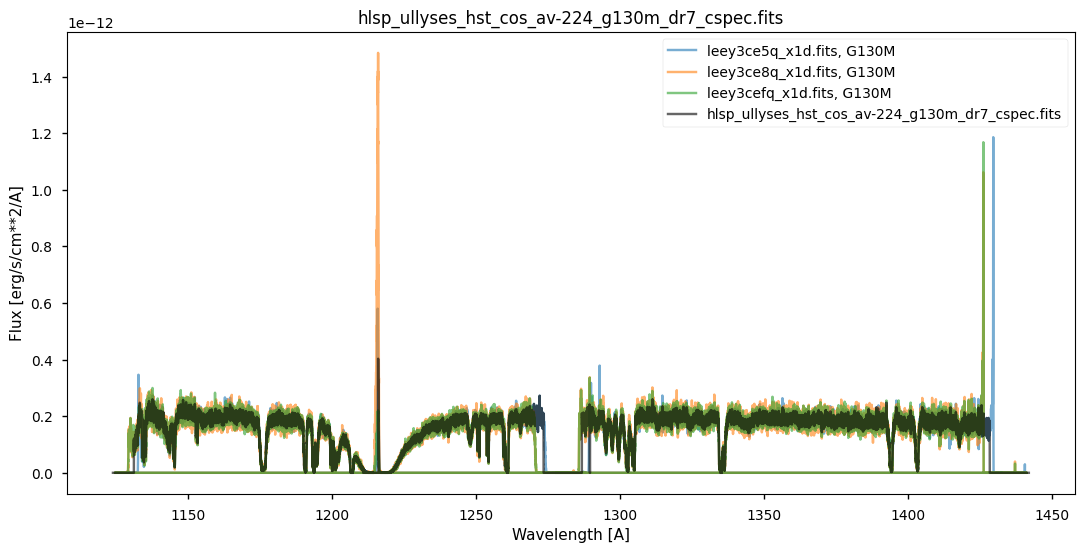

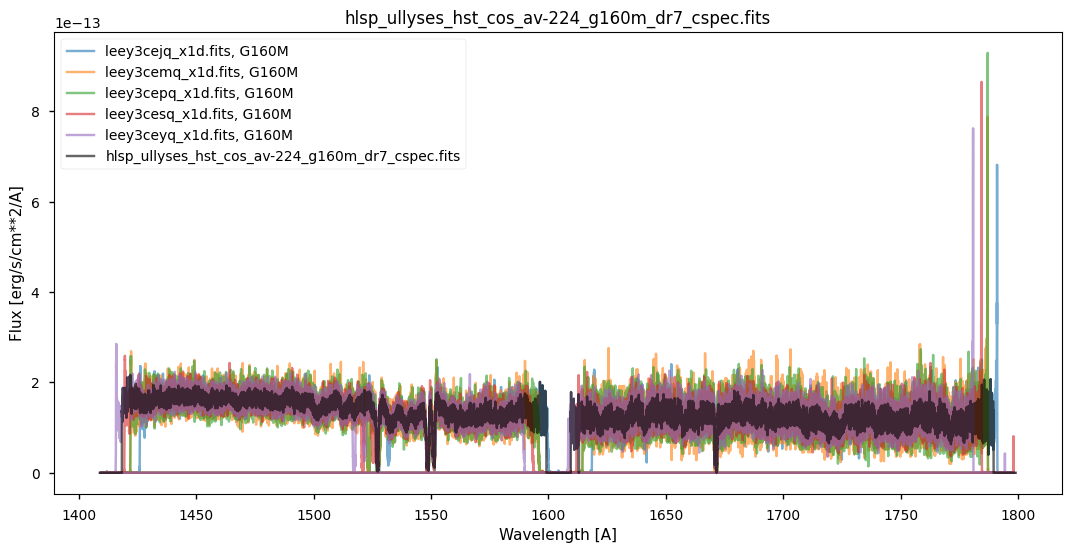

In [8]:
# Let's look at the two level2 products (coadds), and the level4 product (all modes, abutted) product.
products = glob.glob(os.path.join(indir_method_outdir, "*fits"))
for prod in products:
    if fits.getval(prod, "HLSP_LVL") not in [2, 4]:
        continue
    fig,ax = plt.subplots(1, 1, figsize=(13,6))
    prodname = os.path.basename(prod)
    prov = fits.getdata(prod, 2)
    prod_data = fits.getdata(prod)
    input_files = prov["filename"]
    # This just gives us the basename of the input files, we need to add the directory ourselves.
    for infile in input_files:
        infile_path = os.path.join(indir, infile)
        infile_data = fits.getdata(infile_path)
        grating = fits.getval(infile_path, "opt_elem")
        plt.plot(infile_data["wavelength"].flatten(), infile_data["flux"].flatten(), alpha=.6, label=f"{infile}, {grating}")
    ax.plot(prod_data["wavelength"].flatten(), prod_data["flux"].flatten(), alpha=.6, color="black", label=prodname)
    ax.set_xlabel("Wavelength [A]")
    ax.set_ylabel("Flux [erg/s/cm**2/A]")
    ax.legend()
    ax.set_title(prodname)

<a id="sec3"></a>
## Coadd non-ULLYSES data

Creating coadded and abutted products for non-ULLYSES data is similar, but only supports supplying an input list of files, rather than an input directory. You must supply an output directory. 

Optional arguments include: an output filename, and specifying whether existing products should be overwritten. **NOTE**: If an output filename is provided, all input files to be coadded must be of a single grating. If an output filename is not specified, or is set to `None`, one will be constructed on-the-fly of the format `<insrument>_<grating>_coadd.fits`.

In [9]:
# First define the input and output directories
indir = "notebook_download"
generic_outdir = "coadd_generic_infiles"

In [10]:
# Determine list of input files on the fly, or you could specify a specific list
infiles = glob.glob(os.path.join(indir, "*fits"))
coadd_files(infiles, generic_outdir, outfile=None, clobber=True)

notebook_download/leey3cepq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3ceyq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3cejq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3cemq_x1d.fits added to file list for instrument/grating COS/G160M
notebook_download/leey3cesq_x1d.fits added to file list for instrument/grating COS/G160M


/Users/jotaylor/miniconda3/envs/ullyses_dr7/lib/python3.9/site-packages/ullyses/coadd.py:563: RuntimeWarning: invalid value encountered in divide
  thru_nans = segment.data['net'] / segment.data['flux']


Wrote coadd_generic_infiles/cos_g160m_coadd.fits
notebook_download/leey3ce5q_x1d.fits added to file list for instrument/grating COS/G130M
notebook_download/leey3ce8q_x1d.fits added to file list for instrument/grating COS/G130M
notebook_download/leey3cefq_x1d.fits added to file list for instrument/grating COS/G130M
Wrote coadd_generic_infiles/cos_g130m_coadd.fits


<a id="sec31"></a>
### Inspect output products

Notice how the output filename is different when using the generic coadd method, e.g. `cos_g130m_coadd.fits` vs. `hlsp_ullyses_hst_cos_av-224_g130m_dr7_cspec.fits`. 

Let's see how the G130M output file differs from the one we made using the ULLYSES coadd method.

In [11]:
generic_coadd = "coadd_generic_infiles/cos_g130m_coadd.fits"
ullyses_coadd = os.path.join(infiles_method_outdir, "hlsp_ullyses_hst_cos_av-224_g130m_dr7_cspec.fits")
fd = fits.FITSDiff(generic_coadd, ullyses_coadd)
print(fd.report())


 fitsdiff: 6.0.0
 a: coadd_generic_infiles/cos_g130m_coadd.fits
 b: coadd_ullyses_infiles/hlsp_ullyses_hst_cos_av-224_g130m_dr7_cspec.fits
 Maximum number of different data values to be reported: 10
 Relative tolerance: 0.0, Absolute tolerance: 0.0

Primary HDU:

   Headers contain differences:
     Headers have different number of cards:
      a: 34
      b: 40
     Extra keyword 'CAL_VER' in b: 'ULLYSES Cal 4.0.0'
     Extra keyword 'HLSPID' in b: 'ULLYSES'
     Extra keyword 'HLSPLEAD' in b: 'Julia Roman-Duval'
     Extra keyword 'HLSP_LVL' in b: 2
     Extra keyword 'HLSP_VER' in b: 'dr7'
     Extra keyword 'HSLPNAME' in b: 'Hubble UV Legacy Library of Young Stars as Essential Standards'
     Keyword EPOCH    has different values:
          (str) a> 'UNKNOWN'
        (float) b> 2016.0
     Keyword FILENAME has different values:
        a> cos_g130m_coadd.fits
        b> hlsp_ullyses_hst_cos_av-224_g130m_dr7_cspec.fits
     Keyword S_REGION has different values:
        a> CIRCLE 1

As mentioned before, some metadata information is looked up on-the-fly for ULLYSES data. This includes 'official' coordinates and target name of the input target, as can be seen in the differences above. Additionally, keywords specific to the ULLYSES HLSPs are missing in the generic coadded product.

Let's look at the data itself though. It should be identical.

Text(0.5, 1.0, 'Difference between G130M coadds')

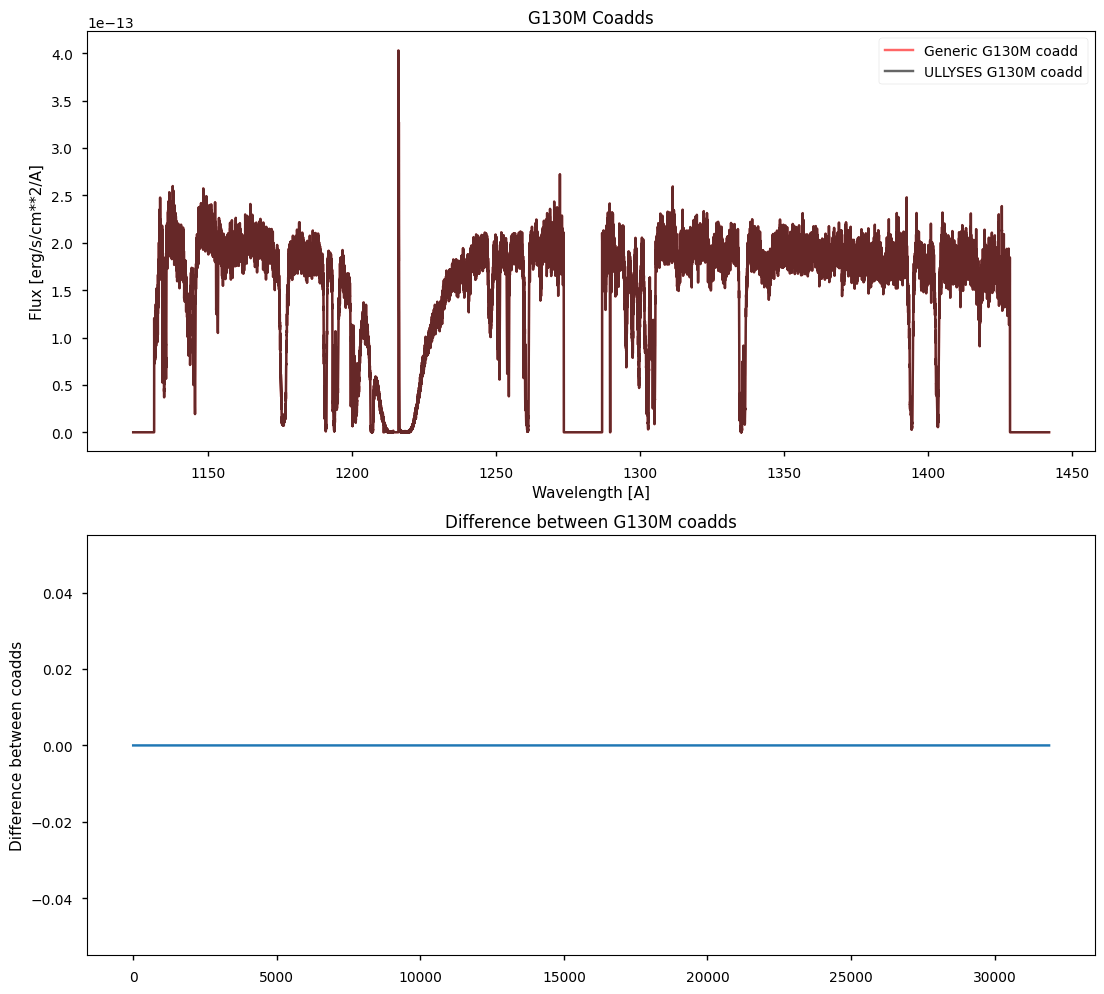

In [12]:
generic_data = fits.getdata(generic_coadd)
ullyses_data = fits.getdata(ullyses_coadd)
fig,axes = plt.subplots(2, 1, figsize=(13,12))
axes = axes.flatten()
axes[0].plot(generic_data["wavelength"].flatten(), generic_data["flux"].flatten(), alpha=.6, color="red", label="Generic G130M coadd")
axes[0].plot(ullyses_data["wavelength"].flatten(), ullyses_data["flux"].flatten(), alpha=.6, color="black", label="ULLYSES G130M coadd")
axes[0].legend()
axes[0].set_xlabel("Wavelength [A]")
axes[0].set_ylabel("Flux [erg/s/cm**2/A]")
axes[0].set_title("G130M Coadds")

diff = generic_data["flux"].flatten() - ullyses_data["flux"].flatten()
axes[1].plot(diff)
axes[1].set_ylabel("Difference between coadds")
axes[1].set_title("Difference between G130M coadds")

The difference between the two coadds is identically zero!

***

## Additional Resources

- [ULLYSES](https://ullyses.stsci.edu)
- [MAST API](https://mast.stsci.edu/api/v0/index.html)

## About this Notebook
For support, contact us at the [ULLYSES Helpdesk](https://stsci.service-now.com/hst?id=sc_cat_item&sys_id=a3b8ec5edbb7985033b55dd5ce961990&sysparm_category=ac85189bdb4683c033b55dd5ce96199c).

**Author:**  Jo Taylor and Elaine M Frazer \
**Updated On:** Dec. 11 2023

## Citations
* See the [ULLYSES website](https://ullyses.stsci.edu/ullyses-cite.html) for citation guidelines.


***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 